import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten

load data

In [2]:
base_dir="Teeth Diseases"
batch=32
img_size=180

split data into tarining and testing 

In [3]:
train_ds=tf.keras.utils.image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_size, img_size),
    batch_size=batch
)

val_ds=tf.keras.utils.image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_size, img_size),
    batch_size=batch
)

Found 11609 files belonging to 6 classes.
Using 9288 files for training.
Found 11609 files belonging to 6 classes.
Using 2321 files for validation.


In [5]:
tooth_disease=train_ds.class_names
print(tooth_disease)

['Calculus', 'Gingivitis', 'Mouth Ulcer', 'Tooth Discoloration', 'caries', 'hypodontia']


visualize

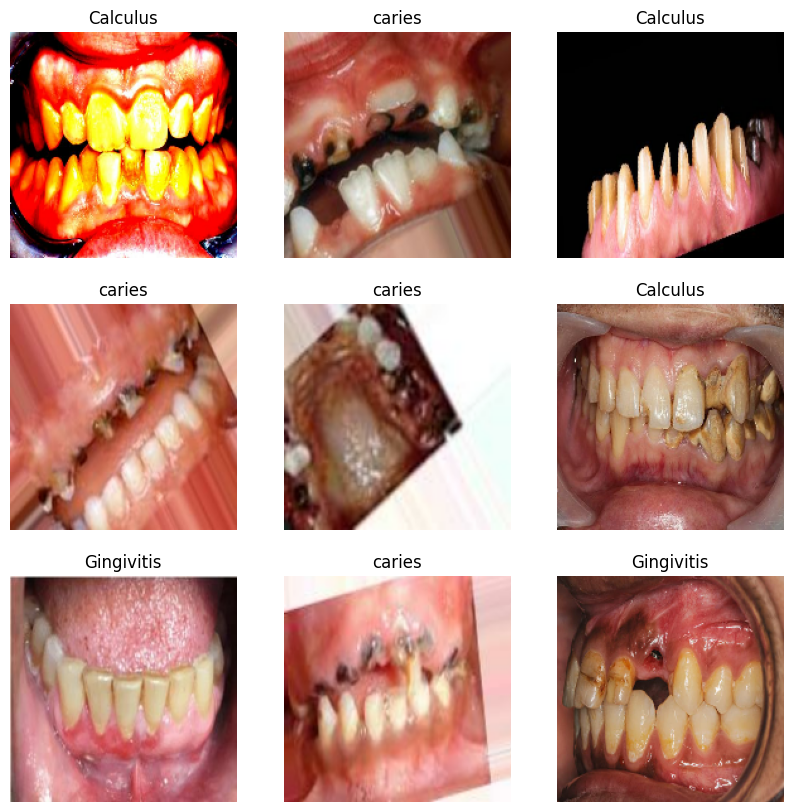

In [6]:
i=0
plt.figure(figsize=(10,10))
for images,labels in train_ds.take(1):
  for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(tooth_disease[labels[i]])
    plt.axis('off')

data autotone

In [7]:
AUTOTOUNE=tf.data.AUTOTUNE
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTOUNE)
val_ds=val_ds.cache().prefetch(buffer_size=AUTOTOUNE)

data augmentation

In [9]:
data_augmentation=tf.keras.Sequential([
                                       layers.RandomFlip('horizontal', input_shape=(img_size,img_size, 3)),
                                       layers.RandomRotation(0.1),
                                       layers.RandomZoom(0.1)
])

c:\Users\jk\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


check visualization data augmentation

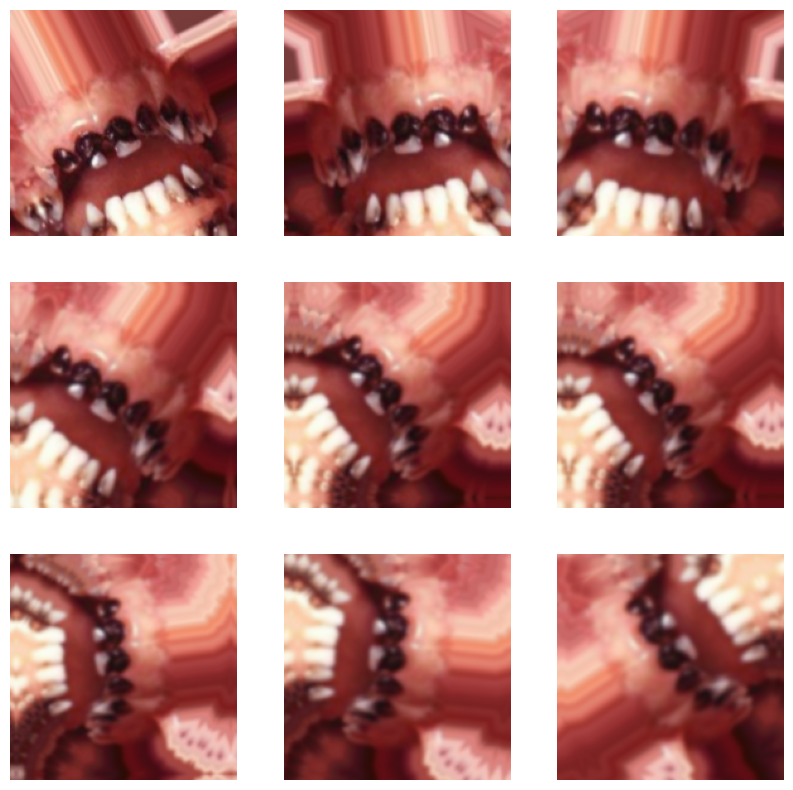

In [10]:
i=0
plt.figure(figsize=(10,10))
for images,labels in train_ds.take(1):
  for i in range(9):
    images=data_augmentation(images)
    plt.subplot(3,3,i+1)
    plt.imshow(images[0].numpy().astype('uint8'))
    plt.axis('off')

build the model

In [11]:
model=Sequential([
                  data_augmentation,
                  layers.Rescaling(1./255),
                  layers.Conv2D(16,3,padding='same',activation='relu'),
                  layers.MaxPooling2D(),
                  layers.Conv2D(32,3,padding='same',activation='relu'),
                  layers.MaxPooling2D(),
                  layers.Conv2D(64,3,padding='same',activation='relu'),
                  layers.MaxPooling2D(),
                  layers.Dropout(0.2),
                  layers.Flatten(),
                  layers.Dense(128),
                  layers.Dense(len(tooth_disease))])

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

data summary

In [13]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,414 (15.22 MB)

 Trainable params: 3,989,414 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

training the model

In [14]:
history=model.fit(train_ds,epochs=25,validation_data=val_ds)

Epoch 1/25
291/291 ━━━━━━━━━━━━━━━━━━━━ 101s 328ms/step - accuracy: 0.3862 - loss: 1.7921 - val_accuracy: 0.5493 - val_loss: 1.1010
Epoch 2/25
291/291 ━━━━━━━━━━━━━━━━━━━━ 90s 309ms/step - accuracy: 0.5704 - loss: 1.0310 - val_accuracy: 0.5748 - val_loss: 1.0987
Epoch 3/25
291/291 ━━━━━━━━━━━━━━━━━━━━ 92s 316ms/step - accuracy: 0.6282 - loss: 0.9070 - val_accuracy: 0.6825 - val_loss: 0.8213
Epoch 4/25
291/291 ━━━━━━━━━━━━━━━━━━━━ 89s 306ms/step - accuracy: 0.6530 - loss: 0.8588 - val_accuracy: 0.6794 - val_loss: 0.7880
Epoch 5/25
291/291 ━━━━━━━━━━━━━━━━━━━━ 92s 315ms/step - accuracy: 0.6660 - loss: 0.8244 - val_accuracy: 0.6295 - val_loss: 0.9640
Epoch 6/25
291/291 ━━━━━━━━━━━━━━━━━━━━ 91s 311ms/step - accuracy: 0.6912 - loss: 0.7705 - val_accuracy: 0.6898 - val_loss: 0.8257
Epoch 7/25
291/291 ━━━━━━━━━━━━━━━━━━━━ 91s 311ms/step - accuracy: 0.6824 - loss: 0.7750 - val_accuracy: 0.7027 - val_loss: 0.7211
Epoch 8/25
291/291 ━━━━━━━━━━━━━━━━━━━━ 92s 315ms/step - accuracy: 0.7073 - loss: 

In [15]:
model.save("teeth_disease_trained_model.h5")